In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from glob2 import glob
from swath_rossby_wave import build_h_matrix2
from swath_rossby_wave import inversion

In [2]:
# define longitude/latitude domain, based on grid points in AVISO subsampled files
lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

In [3]:
# read AVISO SSH
aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = aviso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = aviso_ds.time.data[:] * 86400 # in seconds

lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [4]:
ssha_time_mean = SSHA[:, :, : ].mean(axis = -1) # remove multi-year mean (climatology)

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
# remove mean from SSH data to produce anomaly over full analysis period
SSHA = SSHA - ssha_time_mean 
#  alternately could remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
#    this is not recommended
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

In [6]:
# set Rossby wave model parameters
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 

In [7]:
# number of modes to use---code only tested for MModes = 1
MModes = 1

In [8]:
# set zonal and meridional wavenumber increments and upper/lower bounds
# nominally assume a 10 x 10 degree domain, though we actually use a slightly rectangular domain
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain lognitude length

domain_factor = 1.1 # the smaller, the less waves

l_interval = 2 * np.pi / (domain_factor * L_lat) # zonal wavemenumber interval
k_interval = 2 * np.pi / (domain_factor * L_lon) # longitutional wavemenumber interval

lambda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

k_min = 0  
k_max = 2 * np.pi / lambda_min
l_max = k_max
l_min = -1 * k_max

In [9]:
# set range of k and l
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1  
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lon, zonal propagration 
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lat, meridonal propagration

In [10]:
# set size of wavenumber domain
M = k_n.size * l_n.size

In [11]:
# load stratification, taken from numerical model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [12]:
# parameters for Rossby wave model
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 

In [13]:
# define covariance matrix (R over P)
counter = 0
exp=-2
k0 = l_n.max() # flat at or below k0 

kl, R_over_P = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
p_diagonal = np.zeros([2 * M])
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
R = 0.01 # noise = 1. cm
#R=0.
counter=0

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

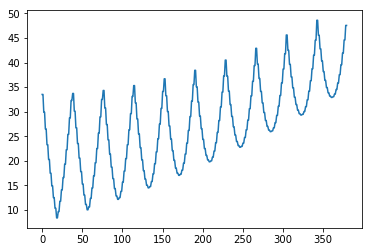

In [14]:
plt.plot(np.diagonal(R_over_P))

In [15]:
day0 = 0
day1 = 40
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [16]:
ndays=40
H_all, SSH_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, 0)

In [17]:
# create a dummy masked matrix in order to build the full H matrix
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

In [18]:
H_all_full_grid, SSH_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)
H_all_full_grid2, SSH_vector2_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, ndays)


In [19]:
day0_array = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

In [20]:
#  case study:  choose initial date for figures and graphical illustration
day=0
day1=day0+ndays
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 
SSHA_vector=np.ma.compressed(MSLA0.transpose([2,0,1]).flatten())
amp_test, ssh_estimated_test = inversion(SSHA_vector, H_all, R_over_P)
SSHA_vector2=np.ma.compressed(MSLA0.transpose([1,0,2]).flatten())
amp_test2, ssh_estimated_test2 = inversion(SSHA_vector2, H_all, R_over_P)

In [21]:
# identify SWOT tracks---here using only 2 sample tracks from one-day repeat orbit
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))
swot_ds = xr.open_mfdataset(swot_files, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})

# Extract the latitudes and longitudes within the swath
latitude = swot_ds['latitude'].values
# longitude = swot_ds['longitude'].values-360
longitude = swot_ds['longitude'].values-360

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


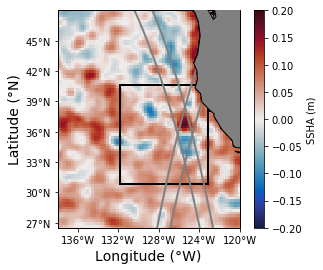

In [22]:
# Figure 1:  large-scale map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# ... [Your function or data loading code]
aviso_ssh = aviso_ds.msla[:, :, day0].data- aviso_ds.msla[:,:,:].mean(axis = -1)
aviso_lon, aviso_lat = aviso_ds.lon.data-360, aviso_ds.lat.data
date_time = aviso_ds.date_time.data[day0:]

# Plotting on a 2D map
plt.figure(figsize=(5,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set background color to white
# ax.background_patch.set_facecolor('white')
plt.pcolor(aviso_lon, aviso_lat, aviso_ssh, cmap= cmo.cm.balance, vmin = -.2, vmax = 0.2)
plt.plot(longitude[:,2],latitude[:,2],color='gray',linewidth=2)
plt.plot(longitude[:,66],latitude[:,66],color='gray',linewidth=2)
plt.axis([-138,-120,26.5,48])
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.colorbar(label='SSHA (m)')
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
# ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='white')


left, bottom, width, height = (lon[0], lat[0],
                               lon[-1] - lon[0],
                               lat[-1]- lat[0])
rect=mpatches.Rectangle((left,bottom),width,height, #latidx_south:latidx_north, 
                        fill=False,
                        color="black",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
# #ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.set_xticks([-136, -132, -128, -124, -120])
ax.set_yticks([27, 30, 33, 36, 39, 42, 45])
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# gl=ax.gridlines(draw_labels=True, color="None")
# gl.xlabels_top = False
# gl.xlines = False

# plt.title('SSH Anomalies')

plt.savefig('./aviso_map_' + str(date_time[day0])[:10] + '.pdf')

In [23]:
for day0 in day0_array[0:1]:
    day1=day0+ndays
    time_range = (day1 - day0) * 2 # forecast time range
    
    MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 
    date_time = aviso_ds.date_time.data[day0:]
        
    variance_explained_inverse  = np.zeros(time_range)
    SSHA_vector=np.ma.compressed(MSLA0.transpose([2,0,1]).flatten())
    amp, ssh_estimated = inversion(SSHA_vector, H_all, R_over_P)
    
    MSLA_fwrd=np.matmul(H_all_full_grid, amp)
    MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
    MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
    MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
    MSLA_fwrd_vector=np.ma.compressed(MSLA_fwrd.transpose([2,0,1]).flatten())
    amp_recover , ssh_recover = inversion(MSLA_fwrd_vector,H_all,R_over_P)
    
    MSLA_fwrd2=np.matmul(H_all_full_grid2, amp)
    MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
    MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
    MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
    
    # ssh_reconstructed.shape
    MSLA_fwrd=np.ma.concatenate((MSLA_fwrd, MSLA_fwrd2),axis=2)
    
    residual = SSHA_masked[:,:,day0:day0+time_range] - MSLA_fwrd

    # evaluate skill (1- rms_residual/rms_ssha_vector) and store the skill
    # skill value nn, ll, mm, = skill value
    #
    variance_explained_inverse = (np.mean(residual**2,axis=(0,1))) / (np.var(SSHA_masked[:,:,day0:day0+time_range],axis=(0,1)))
    
    ds_output = xr.Dataset(data_vars={'l_n' : l_n[:, 0],
                                  'k_n' : k_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), 1-variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[:time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual, fit with ' 
                                                + str(day1 - day0) + '-day prior data.')))
    ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(k_n.size * l_n.size) +'waves_swotdomain_'+ str(int((day1 - day0))) +'days.nc')
    

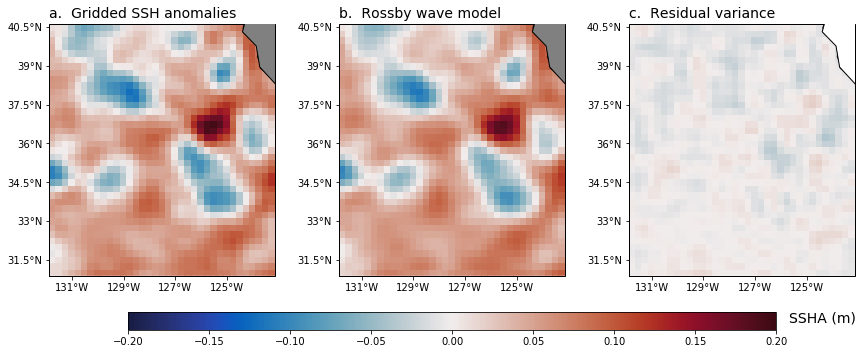

In [27]:
# Figure 2
# plt.figure(figsize = (15, 5))
fig, ax = plt.subplots(1,3,figsize=(15, 5),subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.axes(projection=ccrs.PlateCarree())
i=20

# plt.subplot(131)
ax[0].pcolormesh(lon, lat, SSHA_masked[:,:,i+day0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2) 
ax[0].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[0].coastlines(resolution='50m')
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
# ax[0].colorbar()
# ax[0].xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# ax[0].ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
# ax[0].title('a) AVISO data ' + str(date_time[day0+i])[:10], fontsize = 14)
ax[0].set_title('a.  Gridded SSH anomalies', fontsize=14,loc='left')
ax[0].set_xticks(np.arange(-131,-123,2))
ax[0].set_yticks(np.arange(31.5,42,1.5))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].xaxis.set_major_formatter(lon_formatter)
ax[0].yaxis.set_major_formatter(lat_formatter)
# gl=ax.gridlines(draw_labels=True, color="None")

# plt.subplot(132)
ax[1].pcolormesh(lon, lat, MSLA_fwrd[:, :,i], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
ax[1].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[1].coastlines(resolution='50m')
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
# ax[1].colorbar()
# ax[1].xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# ax[1].ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
ax[1].set_title('b.  Rossby wave model', fontsize=14,loc='left')
# ax[1].title('b) Rossby wave model, 450 waves', fontsize = 14)
ax[1].set_xticks(np.arange(-131,-123,2))
ax[1].set_yticks(np.arange(31.5,42,1.5))
ax[1].xaxis.set_major_formatter(lon_formatter)
ax[1].yaxis.set_major_formatter(lat_formatter)
# plt.colorbar()
# plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
# plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

residual = SSHA_masked[:,:,i+day0] - MSLA_fwrd[:, :, i] 
# plt.subplot(133)
cs=ax[2].pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
ax[2].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[2].coastlines(resolution='50m')
ax[2].add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':')
ax[2].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='white')
# ax[1].colorbar()
# ax[1].xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# ax[1].ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
# ax[1].title('b) Rossby wave model, 450 waves', fontsize = 14)
ax[2].set_xticks(np.arange(-131,-123,2))
ax[2].set_yticks(np.arange(31.5,42,1.5))
ax[2].xaxis.set_major_formatter(lon_formatter)
ax[2].yaxis.set_major_formatter(lat_formatter)
ax[2].set_title('c.  Residual variance', fontsize=14,loc='left')

plt.tight_layout()

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.05])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar_ax.text(1.02,0.45,'SSHA (m)',fontsize=14)
# cbar.ax.set_ylabel('(m)', position=(15,0), fontsize=12, rotation=0)
# plt.colorbar()
# plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
# plt.title('c) Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
# plt.tight_layout()
plt.savefig('./fwrd_ssh_' + str(date_time[day0+day])[:10] +'_day' + str(i) + 'waves.png', dpi = 300)
#plt.close()

In [31]:
# fraction of variance explained by Rossby wave model in Figure 2.
print('fraction of variance explained by Rossby wave model in Figure 2:',variance_explained_inverse[i])

fraction of variance explained by Rossby wave model in Figure 2: 0.030823829824483895


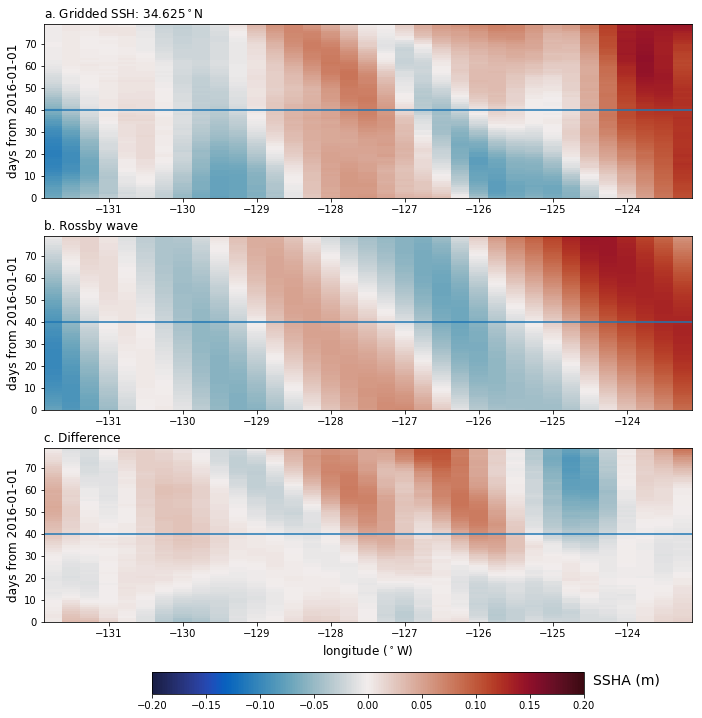

In [26]:
# Figure 3:  Hovmoller diagram

selected_lat = 15
# time = T_time[day0:day0+time_range]/86400  ## use to put calendar dates on y axis
time = np.arange(time_range) # use for day count from start of record
fig, axs = plt.subplots(3, 1,figsize=(10,10))

# plt.figure(figsize = (10, 10))     
SSHA_slice= SSHA_masked[selected_lat, :, day0:day0+time_range].T

axs[0].set_title('a. Gridded SSH: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12, loc='left')
axs[0].pcolormesh(lon, np.arange(time_range),SSHA_slice, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
# plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
# plt.plot(lon, np.repeat(time[day1 - day0],  len(lon)))
axs[0].plot(lon, np.repeat(time[day1], len(lon)))
# plt.colorbar()
# axs[0].set_xlabel('longitude ($^\circ$W)', fontsize = 12)
# plt.ylabel('time (days)', fontsize = 12)
axs[0].set_ylabel('days from '+str(date_time[0])[:10], fontsize = 12)
# plt.yticks(time[0::10], time[0::10] - time[0])
axs[0].set_yticks(time[0::10])

# plt.subplot(312) 
axs[1].set_title('b. Rossby wave', fontsize = 12, loc='left')
axs[1].pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
# plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
axs[1].plot(lon, np.repeat(time[day1], len(lon)))
# plt.colorbar()
# axs[1].set_xlabel('longitude ($^\circ$W)', fontsize = 12)
# plt.ylabel('time (days)', fontsize = 12)
axs[1].set_ylabel('days from '+str(date_time[0])[:10], fontsize = 12)
# plt.yticks(time[0::10], time[0::10] - time[0])
# axs[1].set_yticks(np.arange(0,80,10))
axs[1].set_yticks(time[0::10])

# plt.subplot(313) 
axs[2].set_title('c. Difference' , fontsize = 12, loc='left')
axs[2].pcolormesh(lon, np.arange(80), SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
axs[2].plot(lon, np.repeat(time[day1], len(lon)))
# plt.colorbar()
axs[2].set_xlabel('longitude ($^\circ$W)', fontsize = 12)
axs[2].set_ylabel('days from '+str(date_time[0])[:10], fontsize = 12)
# plt.yticks(time[0::10], time[0::10] - time[0])
axs[2].set_yticks(time[0::10])

plt.tight_layout()

fig.subplots_adjust(bottom=0.17, top=1., left=0.05, right=.95,
                    wspace=0.02, hspace=0.22)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.03])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar_ax.text(1.02,0.45,'SSHA (m)',fontsize=14)

plt.savefig('./Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)